In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from epf import EPF
from ts_dataset import TimeSeriesDataset
from ts_loader import TimeSeriesLoader
from nbeats import Nbeats

In [4]:
# 加载本地数据
Y_df, X_df, S_df = EPF.load(directory='./data')
#Y_df.head()
#X_df.head()
S_df.head()

,unique_id,season_Autumn,season_Spring,season_Summer,season_Winter
0,Local,0,1,0,0
1,Local,0,0,1,0
2,Local,1,0,0,0
3,Local,0,0,0,1


In [3]:
# train_mask: 1 to keep, 0 to mask
train_mask = np.ones(len(Y_df))
train_mask[-7:] = 0 # Last week of data (168 hours)

# 数据集对象。将 DataFrame 预处理为 pytorch 张量和窗口。
ts_dataset = TimeSeriesDataset(Y_df=Y_df, X_df=X_df, S_df=S_df, ts_train_mask=train_mask)
# 打印 t_cols 确认
print(ts_dataset.t_cols)
# 加载对象。采样数据集对象的窗口。
# 有关每个参数的更多信息，请参阅 Loader 对象上的注释。
train_loader = TimeSeriesLoader(model='nbeats',
                                ts_dataset=ts_dataset,
                                window_sampling_limit=8969,  # 4 years of data
                                offset=0,
                                input_size=7,  # Last 7 days
                                output_size=1,  # Predict 1 day
                                idx_to_sample_freq=1,  # Sampling frequency of 1 day
                                batch_size=1024,
                                is_train_loader=True,
                                shuffle=True)

# 验证加载器（注意：在此示例中，我们还对预测期进行了验证）
val_loader = TimeSeriesLoader(model='nbeats',
                              ts_dataset=ts_dataset,
                              window_sampling_limit=8969,  # 4 years of data
                              offset=0,
                              input_size=7,  # Last 7 days
                              output_size=1,  # Predict 1 day
                              idx_to_sample_freq=1,  # Sampling frequency of 1 day
                              batch_size=1024,
                              is_train_loader=False,
                              shuffle=False)

Processing dataframes ...
Creating ts tensor ...
['y', 'GustDir', 'GustSpd', 'WindRun', 'Rain', 'Tmean', 'Tmax', 'Tmin', 'Tgmin', 'VapPress', 'ET10', 'Rad', 'week_day', 'day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'insample_mask', 'outsample_mask']


In [25]:
# 包含要包含的滞后变量的字典。
include_var_dict = {'y': [-7, -6, -5, -4, -3, -2, -1],  # Last 7 days
                    'GustDir': [-7, -6, -5, -4, -3, -2, -1],
                    'GustSpd': [-7, -6, -5, -4, -3, -2, -1],
                    'WindRun': [-7, -6, -5, -4, -3, -2, -1],
                    'Rain': [-7, -6, -5, -4, -3, -2, -1],
                    'Tmean': [-7, -6, -5, -4, -3, -2, -1],
                    'Tmax': [-7, -6, -5, -4, -3, -2, -1],
                    'Tmin': [-7, -6, -5, -4, -3, -2, -1],
                    'Tgmin': [-7, -6, -5, -4, -3, -2, -1],
                    'VapPress': [-7, -6, -5, -4, -3, -2, -1],
                    'ET10': [-7, -6, -5, -4, -3, -2, -1],
                    'Rad': [-7, -6, -5, -4, -3, -2, -1],
                    'week_day': [-1]}  # Last day of the week

model = Nbeats(input_size_multiplier=7,  # Last 7 days
               output_size=1,  # Predict 1 day
               shared_weights=False,
               initialization='glorot_normal',
               activation='selu',
               stack_types=['identity'] + ['exogenous_tcn'],
               n_blocks=[2, 2],
               n_layers=[2, 2],
               n_hidden=[[512, 512], [512, 512]],
               n_harmonics=1,  # not used with exogenous_tcn
               n_polynomials=1,  # not used with exogenous_tcn
               x_s_n_hidden=0,
               exogenous_n_channels=9,
               include_var_dict=include_var_dict,
               t_cols=ts_dataset.t_cols,
               batch_normalization=True,
               dropout_prob_theta=0.2,
               dropout_prob_exogenous=0,
               learning_rate=0.0001,
               lr_decay=0.5,
               n_lr_decay_steps=3,
               early_stopping=10,
               weight_decay=0,
               l1_theta=0,
               n_iterations=10000,
               loss='MAE',
               loss_hypar=0.5,
               val_loss='MAE',
               seasonality=7,  # not used: only used with MASE loss
               random_seed=1)

model.fit(train_ts_loader=train_loader, val_ts_loader=val_loader, eval_steps=50)

D:\Python\lib\site-packages\torch\nn\utils\weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")




============================== Start fitting ==============================
Step: 50, Time: 5.893, Insample MAE: 74.01123, Outsample MAE: 20.46597
Step: 100, Time: 11.683, Insample MAE: 10.53750, Outsample MAE: 2.55759
Step: 150, Time: 17.506, Insample MAE: 2.61723, Outsample MAE: 1.29057
Step: 200, Time: 23.217, Insample MAE: 1.57515, Outsample MAE: 1.32452
Step: 250, Time: 29.056, Insample MAE: 1.43713, Outsample MAE: 1.27398
Step: 300, Time: 34.996, Insample MAE: 1.18433, Outsample MAE: 1.15570
Step: 350, Time: 41.187, Insample MAE: 1.26656, Outsample MAE: 1.13009
Step: 400, Time: 47.423, Insample MAE: 1.16836, Outsample MAE: 1.25164
Step: 450, Time: 53.737, Insample MAE: 1.10245, Outsample MAE: 1.24333
Step: 500, Time: 60.018, Insample MAE: 1.12775, Outsample MAE: 1.24708
Step: 550, Time: 66.310, Insample MAE: 1.16792, Outsample MAE: 1.16764
Step: 600, Time: 72.630, Insample MAE: 1.19659, Outsample MAE: 1.23590
Step: 650, Time: 78.921, Insample MAE: 1.02224, Outsample MAE: 1.2524

In [26]:
y_true, y_hat, *_ = model.predict(ts_loader=val_loader, return_decomposition=False)

In [16]:
print("Y_df['y'].values[-336:]:", Y_df['y'].values[-336:].shape)
print("y_hat:", y_hat.shape)

Y_df['y'].values[-336:]: (336,)
y_hat: (7, 1)


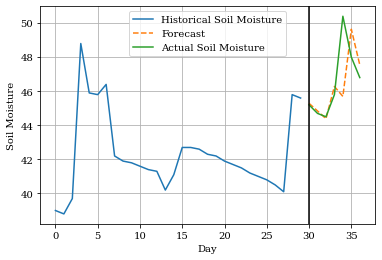

In [27]:
# 设定历史数据和预测数据的长度
history_length = 30  # 用于绘制的历史天数
forecast_length = 7  # 预测天数

# 取历史数据的最后 history_length 天
history_y = Y_df['y'].values[-(history_length + forecast_length):-forecast_length]

# 取预测时间段内的实际数据
actual_y = Y_df['y'].values[-forecast_length:]

# 将预测结果展开并取最后 forecast_length 天的值
y_hat_flat = y_hat.flatten()
y_hat_flat = y_hat_flat[-forecast_length:]

# 确保预测结果和 x 轴长度一致
x_values = range(history_length, history_length + forecast_length)

# 绘制历史数据
plt.plot(range(history_length), history_y, label='Historical Soil Moisture')

# 绘制预测值
plt.plot(x_values, y_hat_flat, linestyle='dashed', label='Forecast')

# 绘制预测时间段内的实际数据
plt.plot(x_values, actual_y, label='Actual Soil Moisture')

# 添加分割线
plt.axvline(history_length, color='black')

# 添加图例、网格和标签
plt.legend()
plt.grid()
plt.xlabel('Day')
plt.ylabel('Soil Moisture')
plt.show()


In [28]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 计算 MSE, MAE 和 MAPE
mse = mean_squared_error(actual_y, y_hat_flat)
mae = mean_absolute_error(actual_y, y_hat_flat)
mape = np.mean(np.abs((actual_y - y_hat_flat) / actual_y)) * 100

print(f'MSE: {mse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'MAPE: {mape:.2f}%')


MSE: 3.6635
MAE: 1.1301
MAPE: 2.31%
